In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
plt.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "serif"

In [2]:
path= '/kaggle/input/kaggle-survey-2022/kaggle_survey_2022_responses.csv'
df_ori= pd.read_csv(path, skiprows= 0)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,208,225,255,257,260,270,271,277) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Data Cleaning and Engineering

In [3]:
# map questions to series
map_questions= df_ori.iloc[0, :]
map_questions.sample(3)

Q12_4     What programming languages do you use on a reg...
Q6_6      On which platforms have you begun or completed...
Q36_13    Do you use any of the following business intel...
Name: 0, dtype: object

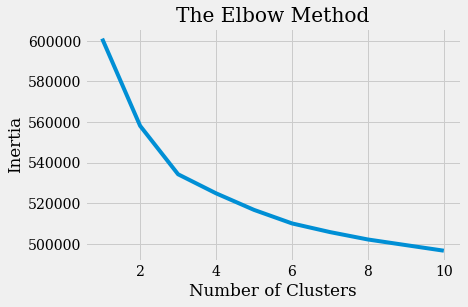

In [4]:
# check how many groups is good

from sklearn.cluster import KMeans

if 'inertias' in locals():
    pass

else:
    inertias= []
    for i in range(1,11):
        kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
        kmeans.fit(pd.get_dummies(
            (df_ori
                .drop(index= 0)
                .drop(columns= 'Duration (in seconds)')
                .replace('No', 0) 
                .replace('Yes', 1)
                .fillna(0)
            ),
            drop_first= True))
        inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [5]:
age_cats= pd.CategoricalDtype(['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', 
                          '45-49', '50-54', '55-59', '60-69', '70+'], ordered= True)
exp_cats= pd.CategoricalDtype(['Blank', 'Not using', 'Under 1 year', '1-2 years', 
                        '2-3 years', '3-4 years','4-5 years', '5-10 years', '10-20 years', 
                        '20 or more years'], ordered= True)
group_cats= pd.CategoricalDtype(['Beginner', 'Intermediate', 'Expert'], ordered= True)
kmeans_model= KMeans(n_clusters= 3, init='k-means++', random_state= 0)

def clean_df(df):
    return(df
        .drop(index= 0) # drop questions rows
        .drop(columns= 'Duration (in seconds)') # drop duration col
        .fillna(0) # fill na with 0
        .replace('No', 0) 
        .replace('Yes', 1)
        .assign(
            Q2= lambda df_: df_['Q2'].astype(age_cats), # age cat
            Q16= lambda df_: (df_['Q16']
                              .replace({0: 'Blank', 'I do not use machine learning methods': 'Not using'})
                              .astype(exp_cats)),
            Group= lambda df_: kmeans_model.fit_predict(pd.get_dummies(df_, drop_first= True)) # group cat, obtained by kmeans
        )
        .assign(
            Group= lambda df_: (df_['Group'].map({0: 'Intermediate', 1: 'Expert', 2: 'Beginner'})).astype(group_cats)
        )
    )

In [6]:
df= clean_df(df_ori)

# EDA

In [233]:
def plot_var_per_group(var, var_name, annotate= False, palette= 'summer'):
    plt.figure(figsize= (15, 5))   
    try:
        ax= sns.barplot(
            data= (df
                    .groupby('Group')[var]
                    .value_counts(normalize= True)
                    .mul(100)
                    .to_frame()
                    .reset_index()
                    .rename({'level_1': var_name, var: 'Percentage'}, axis= 'columns')
                    ),
            y= 'Percentage',
            x= 'Group',
            hue= var_name,
            palette= palette
        )  
    except:
         ax= sns.barplot(
            data= (df
                .groupby('Group')[var]
                .value_counts(normalize= True)
                .mul(100)
                .to_frame()
                .rename(columns= {var: 'Percentage'})
                .reset_index()
                .rename({var: var_name}, axis= 'columns')
            ),
            y= 'Percentage',
            x= 'Group',
            hue= var_name,
            palette= palette
        )       
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals= 0))
    plt.legend(ncol= 6, loc= 'upper center', bbox_to_anchor=(0.5, 1.2), frameon= False)
    title= map_questions[var]
    plt.title(title, fontsize= 30, fontweight= 'bold', pad= 80)
    plt.ylabel('Percentage')
    plt.xlabel('')
    if annotate == True:
        for p in ax.patches:
            ax.annotate(format(p.get_height()/100, '.2%',), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           size= 12,
                           xytext = (0, 10), 
                           textcoords = 'offset points')
    plt.show()
    
    
def plot_var_per_group2(df1, df2, y, title, upper_xlim):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1= sns.barplot(
        data= df1,
        y= y,
        x= 'value',
        hue= 'Group',
        palette= 'Set1',
        ax= ax1
    )
    ax2= sns.barplot(
        data= df2,
        y= y,
        x= 'value',
        hue= 'Group', 
        palette= 'Set1',
        ax= ax2
    )
    for ax in (ax1, ax2):
        ax.legend([],[], frameon=False) 
        ax.set_ylabel('')
        ax.set_xlabel('Count')
        ax.set_xlim(0, upper_xlim)
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor= (0.5, 1.05), ncol= 3, frameon= False)
    plt.suptitle(title, fontsize= 30, fontweight= 'bold', y= 1.3)
    plt.show()
    
def plot_bidirectional_barplot(suptitle, index, column1, title1, column2, title2, plot_size, title_pad= 25):
    color1= '#1f77b4'
    color2= '#d62728'

    fig, (ax1, ax2) = plt.subplots(figsize= plot_size, ncols=2, sharey= True)

    ax1.barh(index, column1, align='center', color= color1, zorder=10)
    ax1.set_title(title1, fontsize=18, pad= title_pad, color= color1)

    ax2.barh(index, column2, align='center', color= color2, zorder=10)
    ax2.set_title(title2, fontsize=18, pad= title_pad, color= color2)

    plt.gca().invert_yaxis() # sort y-axis a-z
    ax1.invert_xaxis() # invery y axis from ax2

    # sey both ylim to 0-100
    ax2.set_xticks(list(range(0, 120, 20)))
    ax2.set_xticks(list(reversed((range(0, 120, 20)))))

    for ax in (ax1, ax2):
#         ax.xaxis.set_visible(False)
        ax.xaxis.tick_top()
        ax.tick_params(axis='x', which='major', pad= -(ax.get_ylim()[0]/2))
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.bottom.set_visible(False)
        
    plt.suptitle(suptitle, fontsize= 30, fontweight= 'bold', y= 1)

    fig.tight_layout()
    plt.show()

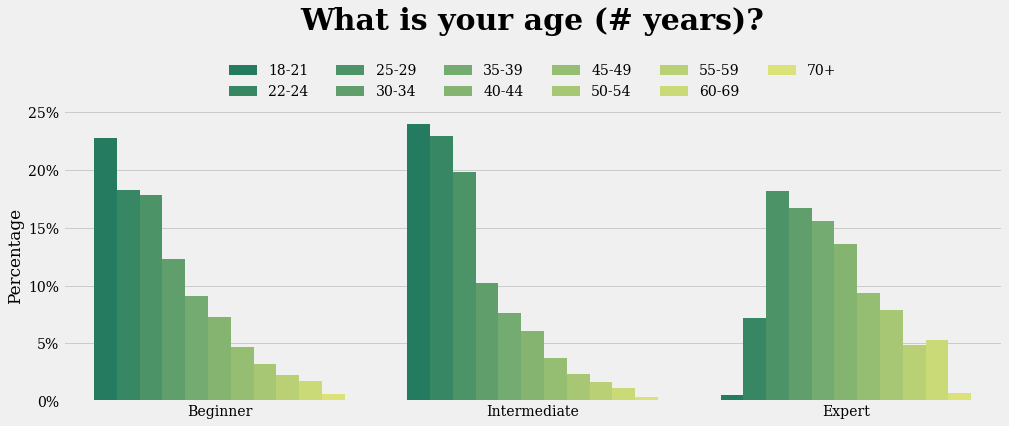

In [8]:
plot_var_per_group('Q2', 'Age')

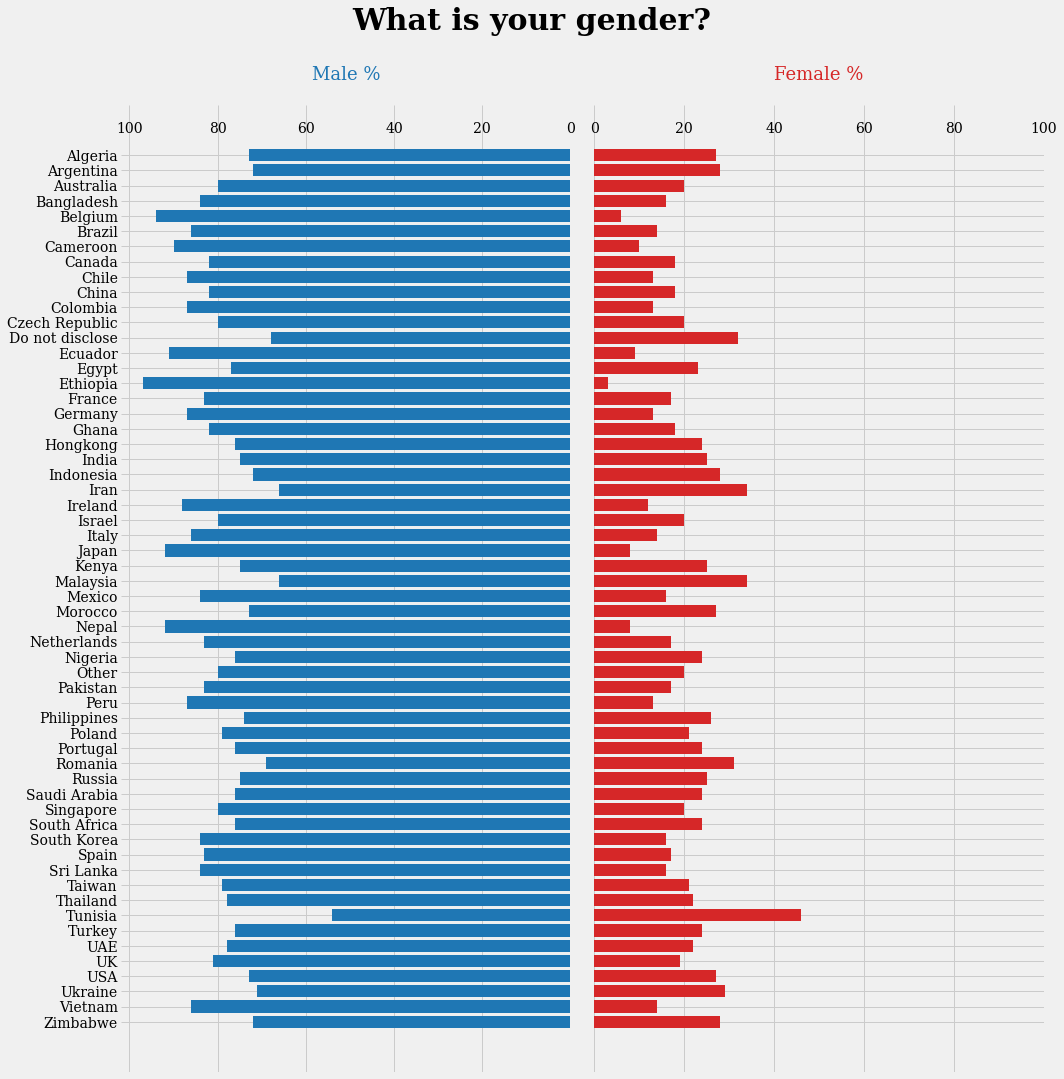

In [234]:
map_country= {
    'United States of America': 'USA',
    'United Kingdom of Great Britain and Northern Ireland': 'UK',
    'Iran, Islamic Republic of...': 'Iran',
    'Viet Nam': 'Vietnam',
    'United Arab Emirates': 'UAE',
    'Hong Kong (S.A.R.)': 'Hongkong',
    'I do not wish to disclose my location': 'Do not disclose'
}

df_q4= (df
    ['Q4']
    .replace(map_country)
    .to_frame()
    .assign(
        Gender= df['Q3'].where(df['Q3'].isin(['Man', 'Woman']), 'Other')
    )
    .query('`Gender` != "Other"')
    .groupby(['Q4', 'Gender'])
    .agg(Count= ('Gender', 'size'))
    .reset_index()
    .rename(columns= {'Q4': 'Nationality'})
    .assign(Perc= lambda df_: round(((df_['Count'] / df_.groupby('Nationality')['Count'].transform('sum'))* 100), 0))
    .pivot(index= 'Nationality', columns= 'Gender', values= 'Perc')
)

plot_bidirectional_barplot(
    suptitle= 'What is your gender?',
    index = df_q4.index, 
    column1 = df_q4['Man'], title1 = 'Male %', 
    column2 = df_q4['Woman'], title2 = 'Female %', 
    plot_size= (15,15)
)

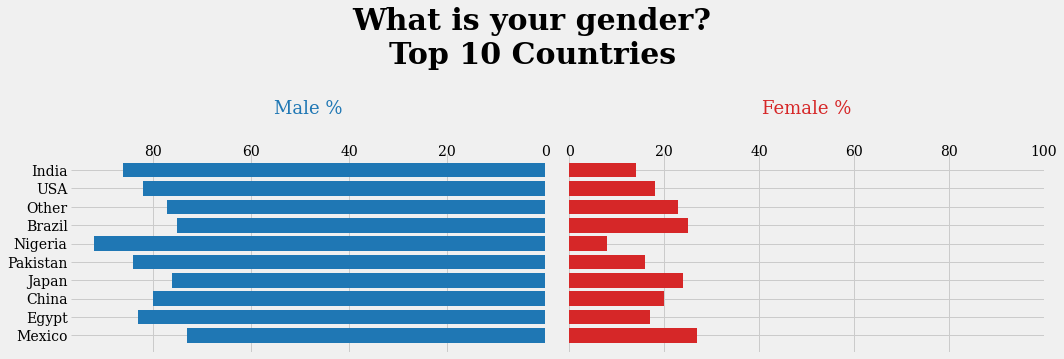

In [266]:
top10_countries= df['Q4'].value_counts()[:10].index.tolist()
# replace united states with usa
top10_countries= ['USA' if x == 'United States of America' else x for x in top10_countries] 

df_q4_selected= (df_q4
    .loc[df_q4.index.isin(top10_countries)]
    .set_index(pd.CategoricalIndex(top10_countries, ordered= True))
)

plot_bidirectional_barplot(
    suptitle= 'What is your gender?\nTop 10 Countries',
    index = df_q4_selected.index, 
    column1 = df_q4_selected['Man'], title1 = 'Male %', 
    column2 = df_q4_selected['Woman'], title2 = 'Female %', 
    plot_size= (15, 5),
    title_pad= 40
)

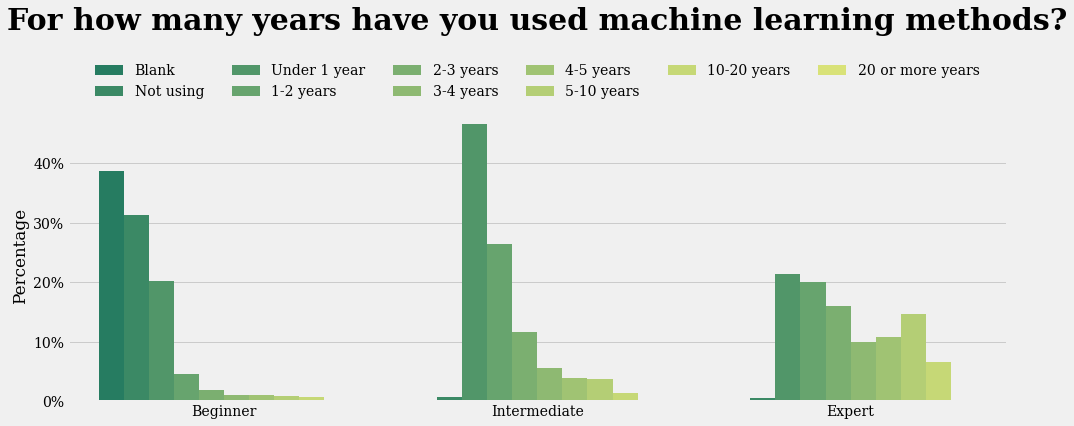

In [13]:
plot_var_per_group('Q16', 'ML Experience')

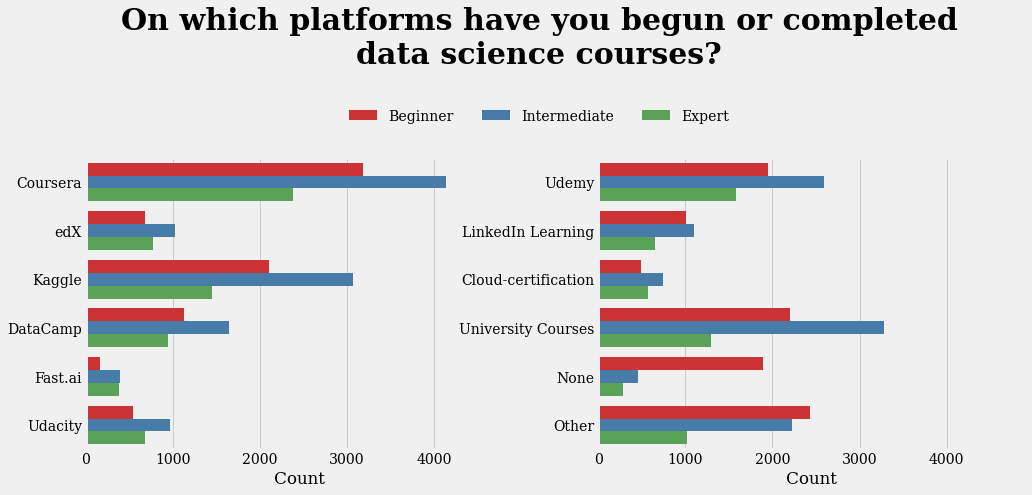

In [14]:
import re
mask_question= df.columns[df.columns.str.contains('Q6')]
df_q6= (df[mask_question]
    .mask(df != 0, 1)
    .rename(columns= dict(map_questions))
    .join(df['Group'])
)
df_q6.columns= (df_q6.columns
    .str.replace('On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - ', '', regex= False)
    .str.replace(' (direct from AWS, Azure, GCP, or similar)', '', regex= False)
    .str.replace(' (resulting in a university degree)', '', regex= False)
    .str.replace(' Learn Courses', '', regex= False)
    .str.replace(' programs', '', regex= False)
)
df_q6= (df_q6
    .groupby('Group')
    .sum()
    .reset_index()
    .melt(id_vars= 'Group')
)

plot_var_per_group2(
    df_q6.iloc[0:int(len(df_q6)/2),:],
    df_q6.iloc[int(len(df_q6)/2):,:], 
    'variable', 
    "On which platforms have you begun or completed\ndata science courses?", 
    4900
)